# Error detection

## Method 1 - Presence of junctions

In [3]:
# read pred skeletons
prefix = "pred-all" # TO CHANGE
output_resolution=(80,80,80)
from ibex.utilities.dataIO import *
pred_skeletons = ReadSkeletons(prefix, read_edges=True, downsample_resolution=output_resolution)
print len(pred_skeletons)

/home/srujanm/anaconda2/envs/em/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3660


In [24]:
# test junctions function
print pred_skeletons[42].get_junctions()

[]


In [25]:
# find all skeletons with junctions
flag_branched = []
flag_skipped = []
for sk in pred_skeletons:
    junctions = sk.get_junctions()
    if junctions is None:
        flag_skipped.append(sk.label)
    elif len(junctions)>0:
        flag_branched.append(sk.label)
print len(flag_branched)
print len(flag_skipped)

590
21


## Method 2 - Cap number of nodes

In [70]:
def find_heavy(skeletons, node_thresh):
    """Finds labels of skeletons with #nodes greater than a threshold"""
    flag_heavy = []
    for sk in skeletons:
        if len(sk.endpoints)+len(sk.joints) > node_thresh:
            flag_heavy.append(sk.label)
    return flag_heavy

In [72]:
# sweep node_thresh
node_threshs = [40, 50, 60, 70]
heavy_results = [find_heavy(pred_skeletons, t) for t in node_threshs]

## Method 3 - Cap run length

In [5]:
def find_long(skeletons, length_thresh):
    """Finds labels of skeletons with run length greater than a threshold"""
    flag_long = []
    for sk in skeletons:
        if sk.length() > length_thresh:
            flag_long.append(sk.label)
    return flag_long

In [7]:
import json
with open('data_locs.json') as f:
    data_locs = json.load(f)
block_length = data_locs["block-size"]*pred_skeletons[0].resolution[0]

# sweep length_thresh
length_threshs = np.multiply(np.array([1,5, 2, 2.5]), block_length)
long_results = [find_long(pred_skeletons, t) for t in length_threshs]

# Validate against GT skeletons

In [8]:
# read merge errors identified in GT skeleton analysis
def read_merges(read_path):
    f = open(read_path + "/merged.ids", "r")
    n_pairs = int(f.readline()) # no of pairs of GT merged skeletons
    merge_ids = f.readlines()[::2]
    for i, mstr in enumerate(merge_ids):
        merge_ids[i] = int(mstr)
    merge_ids = list(set(merge_ids))
    return merge_ids

# read correct IDs identified in GT skeleton analysis
def read_corrects(read_path):
    f = open(read_path + "/correct.ids", "r")
    n_corr = int(f.readline()) # no of pairs of GT merged skeletons
    corr_ids = f.readlines()
    for i, cstr in enumerate(corr_ids):
        corr_ids[i] = int(cstr.split(',')[1])
    return corr_ids

In [9]:
err_analysis_path = 'skeletons/'+prefix+'/error-analysis/'

merge_ids = read_merges(err_analysis_path)
corr_ids = read_corrects(err_analysis_path)

import json
with open(err_analysis_path + 'error-analysis-summary.json') as f:
    err_summ = json.load(f)
assert len(corr_ids) == err_summ["results"]["correct"]

print "# merges from GT analysis: %d"%(len(merge_ids))
print "# corrects from GT analysis: %d"%(len(corr_ids))

# merges from GT analysis: 47
# corrects from GT analysis: 712


In [32]:
def pr_analysis(detected_ids, merge_ids, corr_ids, write_path=None):
    true_pos = list(set(merge_ids)&(set(detected_ids)))
    print "True positives: %d"%(len(true_pos))
    false_pos = list(set(corr_ids)&(set(detected_ids)))
    print "False positives: %d"%(len(false_pos))
    true_neg = list(set(corr_ids).difference(set(detected_ids)))
    print "True negatives: %d"%(len(true_neg))
    false_neg = list(set(merge_ids).difference(set(detected_ids)))
    print "False negatives: %d"%(len(false_neg))
    precision = len(true_pos)/(1.*len(true_pos)+len(false_pos))
    recall = len(true_pos)/(1.*len(true_pos)+len(false_neg))
    print "Precision: %f"%(precision)
    print "Recall: %f"%(recall)
    
    print false_pos
    print false_neg
    
    if write_path is not None:
        np.save(write_path+'false_pos', false_pos)
        np.save(write_path+'false_neg', false_neg)
        np.save(write_path+'true_pos', true_pos)
        np.save(write_path+'true_neg', true_neg)
    return (precision, recall)

True positives: 19
False positives: 15
True negatives: 697
False negatives: 28
Precision: 0.558824
Recall: 0.404255
True positives: 12
False positives: 10
True negatives: 702
False negatives: 35
Precision: 0.545455
Recall: 0.255319
True positives: 7
False positives: 4
True negatives: 708
False negatives: 40
Precision: 0.636364
Recall: 0.148936
True positives: 5
False positives: 2
True negatives: 710
False negatives: 42
Precision: 0.714286
Recall: 0.106383


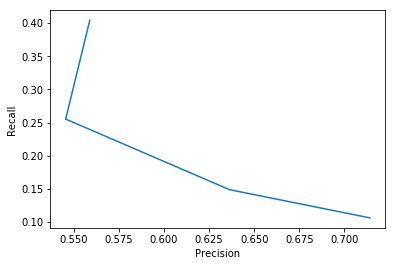

In [11]:
# plot PR curve sweeping error detection method params
import matplotlib.pyplot as plt

pr_results = [pr_analysis(result, merge_ids, corr_ids) for result in long_results]
p = [res[0] for res in pr_results]
r = [res[1] for res in pr_results]
plt.plot(p,r)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

In [26]:
# inspect results for best parameter choice
long_ids = find_long(pred_skeletons, 1.5*block_length)
print len(long_ids)

316
True positives: 28
False positives: 26
True negatives: 686
False negatives: 19
Precision: 0.518519
Recall: 0.595745


(0.5185185185185185, 0.5957446808510638)

In [33]:
write_path='skeletons/'+prefix+'/error-detection/'

detected_ids = list(set(flag_branched))
pr_analysis(detected_ids, merge_ids, corr_ids, write_path=write_path)

True positives: 39
False positives: 78
True negatives: 634
False negatives: 8
Precision: 0.333333
Recall: 0.829787
[1414, 1189, 2434, 1411, 1317, 2310, 3593, 2314, 2445, 1679, 1040, 1427, 2708, 1685, 1560, 1945, 1436, 2501, 1136, 1702, 2211, 1316, 1061, 422, 1948, 1194, 2475, 3620, 1716, 1462, 1079, 1592, 1337, 1470, 3573, 3520, 1474, 1643, 2373, 1862, 1223, 1096, 3574, 2507, 3532, 1101, 1485, 2514, 3543, 3544, 985, 1372, 2397, 1630, 2399, 2272, 2402, 995, 1090, 2405, 1126, 2408, 3558, 2794, 1515, 1346, 2157, 1670, 2159, 2160, 2164, 1269, 2422, 1401, 2298, 1659, 1404, 2431]
[1152, 1282, 1704, 1180, 1002, 3501, 2388, 3516]


(0.3333333333333333, 0.8297872340425532)

In [28]:
# load IDs that are false negatives
false_negs = np.load(write_path+'false_neg.npy')
false_pos = np.load(write_path+'false_pos.npy')
# save skeletons
for i in false_negs:
    pred_skeletons[i].save_image(write_path+'/false-neg/')
# for i in false_pos:
#     pred_skeletons[i].save_image(write_path+'/false-pos/')

In [66]:
# save images of detected skeletons
# save_path = 'skeletons/'+prefix+'/error-detection/'
# for i in detected_ids:
#     pred_skeletons[i].save_image(save_path)